In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
import optuna
from optuna.trial import TrialState
from tab_transformer_pytorch import FTTransformer, TabTransformer
import sys
sys.path.append('../model/')
from updatedModel import train, test
import time
from torch import Tensor
from typing import Literal

device_in_use='cuda'

c:\Users\smbm2\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# df_train = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/income/train.csv')
# df_test = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/income/test.csv')
# df_val = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/income/validation.csv') #READ FROM RIGHT SPOT

df_train = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\income\train.csv')
df_test = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\income\test.csv')
df_val = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\income\validation.csv') #READ FROM RIGHT SPOT

In [3]:
cont_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week']
cat_columns = ['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country']
target = ['income']

#CHECKING TO MAKE SURE YOUR LIST IS CORRECT (NO NEED TO TOUCH)
yourlist = cont_columns + cat_columns+target
yourlist.sort()
oglist = list(df_train.columns)
oglist.sort()

assert(yourlist == oglist), "You may of spelled feature name wrong or you forgot to put on of them in the list"

cat_features = (10,16,7,16,6,5,2,43)

target_classes = [max(len(df_train[target].value_counts()), len(df_val[target].value_counts()),len(df_test[target].value_counts()))]

# Create a StandardScaler and fit it to the cont features
scaler = StandardScaler()
scaler.fit(df_train[cont_columns])

# Transform the training, test, and validation datasets
df_train[cont_columns] = scaler.transform(df_train[cont_columns])
df_test[cont_columns] = scaler.transform(df_test[cont_columns])
df_val[cont_columns] = scaler.transform(df_val[cont_columns])

class SingleTaskDataset(Dataset):
    def __init__(self, df : pd.DataFrame, cat_columns, num_columns,task1_column):
        self.n = df.shape[0]
        
        self.task1_labels = df[task1_column].astype(np.float32).values

        self.cate = df[cat_columns].astype(np.int64).values
        self.num = df[num_columns].astype(np.float32).values


    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        # Retrieve features and labels from the dataframe using column names
        cat_features = self.cate[idx]
        num_features = self.num[idx]
        labels_task1 = self.task1_labels[idx]

        return cat_features, num_features, labels_task1

#Wrapping in Dataset
train_dataset = SingleTaskDataset(df_train, cat_columns, cont_columns, 'income')
val_dataset = SingleTaskDataset(df_val, cat_columns, cont_columns, 'income')
test_dataset = SingleTaskDataset(df_test, cat_columns, cont_columns, 'income')

#This is a hyperparameter that is not tuned. Maybe mess with what makes sense here
#Also try looking to see what other papers have done
batch_size = 256

# Wrapping with DataLoader for easy batch extraction
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()

        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert(self.head_dim * heads == embed_size), "Embed size needs to be div by heads"
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys =nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size)


    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3) #(batch_size, head_dim, #query_embeddings, #key_embeddings)

        # Calculate simplified attention scores
        avg_attention = attention.mean(dim=0)  # Average across batches
        # print("batch average", avg_attention.shape)
        avg_attention = avg_attention.mean(dim=0).squeeze(dim=0)
        # print("head average", avg_attention.shape)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads*self.head_dim) #(batch_size, n_features, embed_size)
        out = self.fc_out(out)

        return out, avg_attention
    
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion, pre_norm_on):
        super(TransformerBlock, self).__init__()

        self.pre_norm_on = pre_norm_on
        if self.pre_norm_on:
            self.pre_norm = nn.LayerNorm(embed_size)
        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(nn.Linear(embed_size, forward_expansion*embed_size),
                                          nn.ReLU(),
                                          nn.Linear(forward_expansion*embed_size, embed_size)
                                          )
        self.dropout = nn.Dropout(dropout)

    def forward(self,value,key,query):
        if self.pre_norm_on:
            query = self.pre_norm(query)
            key = self.pre_norm(key)
            value = self.pre_norm(value)
            
        attention, avg_attention = self.attention(value, key, query)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out, avg_attention
    
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, pre_norm_on):
        super(DecoderBlock, self).__init__()

        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(embed_size, heads, dropout, forward_expansion, pre_norm_on)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key):
        out, avg_attention = self.transformer_block(value, key, x)

        return out, avg_attention

class Decoder(nn.Module):
    def __init__(self,
                 embed_size,
                 num_layers,
                 heads,
                 forward_expansion,
                 decoder_dropout,
                 pre_norm_on
    ):
        super(Decoder, self).__init__()

        self.layers = nn.ModuleList(
                [
                    DecoderBlock(
                        embed_size,
                        heads,
                        dropout=decoder_dropout,
                        forward_expansion=forward_expansion,
                        pre_norm_on=pre_norm_on
                    )
                    for _ in range(num_layers)
                ]
            )
        self.avg_attention = None

    def forward(self, class_embed, context):
        for layer in self.layers:
            # x is the classification embedding (CLS Token)
            # context are the feature embeddings that will be used as key and value
            x, self.avg_attention = layer(class_embed, context, context)
  
        return x 

class EmbeddingsRFFforIndividualFeatures(nn.Module):
    def __init__(self, sigma, embed_size, input_size, n_cont, cat_feat, num_target_labels, rff_on, linear_on:bool):
        super(EmbeddingsRFFforIndividualFeatures, self).__init__()

        self.rff_on = rff_on

        self.linear_on = linear_on

        if self.rff_on:
            self.rffs = nn.ModuleList([GaussianEncoding(sigma=sigma, input_size=input_size, encoded_size=embed_size//2) for _ in range(n_cont)])
            self.mlp_in = embed_size
        else:
            self.mlp_in = input_size

        if self.linear_on:
            self.cont_embeddings = nn.ModuleList([nn.Linear(in_features=self.mlp_in, out_features=embed_size) for _ in range(n_cont)])
            self.cont_embeddings2 = nn.ModuleList([nn.Linear(in_features=self.mlp_in, out_features=embed_size) for _ in range(n_cont)])

        self.cat_embeddings = nn.ModuleList([nn.Embedding(num_classes, embed_size) for num_classes in cat_feat])

        # Classifcation Embeddings for each target label
        self.target_label_embeddings = nn.ModuleList([nn.Embedding(1, embed_size) for _ in range(num_target_labels)])

        self.relu = nn.ReLU()


    def forward(self, cat_x, cont_x):
        x = cont_x.unsqueeze(2) #(batch_size, n_features) -> (batch_size, n_features, 1)
        rff_vectors = []
        if self.rff_on:
            for i, r in enumerate(self.rffs):
                input = x[:,i,:]
                out = r(input)
                rff_vectors.append(out)

        embeddings = []
        if self.linear_on:
            x = torch.stack(rff_vectors, dim=1)
            for i, e in enumerate(self.cont_embeddings):
                goin_in = x[:,i,:]
                goin_out = e(goin_in)
                goin_out = self.cont_embeddings2[i](goin_out) #Adding in the extra layer to see if it helps
                embeddings.append(goin_out)
        else:
            embeddings = rff_vectors

        #embedding cat features
        cat_x = cat_x.unsqueeze(2)
        for i, e in enumerate(self.cat_embeddings):

            goin_in = cat_x[:,i,:]
  
            goin_out = e(goin_in)
            goin_out=goin_out.squeeze(1)
            embeddings.append(goin_out)

        target_label_embeddings_ = []
        for e in self.target_label_embeddings:
            input = torch.tensor([0], device=x.device)
            temp = e(input)
            temp = temp.repeat(x.size(0), 1)
            tmep = temp.unsqueeze(1)
            target_label_embeddings_.append(temp)

        class_embeddings = torch.stack(target_label_embeddings_, dim=1)

        context = torch.stack(embeddings, dim=1)


        return class_embeddings, context

class EmbeddingsRFFforAllFeatures(nn.Module):
    def __init__(self, sigma, embed_size, input_size, n_cont, cat_feat, num_target_labels, rff_on, linear_on:bool):
        super(EmbeddingsRFFforAllFeatures, self).__init__()

        self.rff_on = rff_on
        self.n_cont = n_cont
        self.linear_on=linear_on

        if self.rff_on:
            self.rff = GaussianEncoding(sigma=sigma, input_size=input_size, encoded_size=embed_size//2) 
            self.mlp_in = embed_size
        else:
            self.mlp_in = input_size

        if self.linear_on:
            self.cont_embeddings = nn.ModuleList([nn.Linear(in_features=self.mlp_in, out_features=embed_size) for _ in range(n_cont)])
            self.cont_embeddings2 = nn.ModuleList([nn.Linear(in_features=self.mlp_in, out_features=embed_size) for _ in range(n_cont)])

        self.cat_embeddings = nn.ModuleList([nn.Embedding(num_classes, embed_size) for num_classes in cat_feat])

        # Classifcation Embeddings for each target label
        self.target_label_embeddings = nn.ModuleList([nn.Embedding(1, embed_size) for _ in range(num_target_labels)])


    def forward(self, cat_x, cont_x):
        x = cont_x.unsqueeze(2) #(batch_size, n_features) -> (batch_size, n_features, 1)
        rff_vectors = []
        if self.rff_on:
            for i in range(self.n_cont):
                input = x[:,i,:]
                out = self.rff(input)
                rff_vectors.append(out)
        
        embeddings = []
        if self.linear_on:
            x = torch.stack(rff_vectors, dim=1)
            for i, e in enumerate(self.cont_embeddings):
                goin_in = x[:,i,:]
                goin_out = e(goin_in)
                goin_out = self.cont_embeddings2[i](goin_out)
                embeddings.append(goin_out)
        else:
            embeddings = rff_vectors

        #embedding cat features
        cat_x = cat_x.unsqueeze(2)
        for i, e in enumerate(self.cat_embeddings):

            goin_in = cat_x[:,i,:]
  
            goin_out = e(goin_in)
            goin_out=goin_out.squeeze(1)
            embeddings.append(goin_out)

        target_label_embeddings_ = []
        for e in self.target_label_embeddings:
            input = torch.tensor([0], device=x.device)
            temp = e(input)
            temp = temp.repeat(x.size(0), 1)
            tmep = temp.unsqueeze(1)
            target_label_embeddings_.append(temp)

        class_embeddings = torch.stack(target_label_embeddings_, dim=1)

        context = torch.stack(embeddings, dim=1)

        return class_embeddings, context
    
class PeriodicActivation(nn.Module):
    def __init__(self, sigma, embed_size, input_size, n_cont, cat_feat, num_target_labels,trainable: bool, initialization: str, linear_on:bool):
        super(PeriodicActivation, self).__init__()

        self.n = embed_size
        self.sigma = sigma
        self.trainable = trainable
        self.initialization = initialization
        self.linear_on = linear_on
        self.n_cont = n_cont

        if self.initialization == 'log-linear':
            coefficients = self.sigma ** (torch.arange(self.n//2) / self.n)
            coefficients = coefficients[None]
        else:
            assert self.initialization == 'normal'
            coefficients = torch.normal(0.0, self.sigma, (1, self.n//2))

        if self.trainable:
            self.coefficients = nn.Parameter(coefficients)
        else:
            self.register_buffer('coefficients', coefficients)

        if self.linear_on:
            self.cont_embeddings = nn.ModuleList([nn.Linear(in_features=embed_size, out_features=embed_size) for _ in range(n_cont)])

        self.cat_embeddings = nn.ModuleList([nn.Embedding(num_classes, embed_size) for num_classes in cat_feat])

        # Classifcation Embeddings for each target label
        self.target_label_embeddings = nn.ModuleList([nn.Embedding(1, embed_size) for _ in range(num_target_labels)])


    def forward(self, cat_x, cont_x):
        x = cont_x.unsqueeze(2) #(batch_size, n_features) -> (batch_size, n_features, 1)

        temp = []
        for i in range(self.n_cont):
            input = x[:,i,:]
            out = torch.cat([torch.cos(self.coefficients * input), torch.sin(self.coefficients * input)], dim=-1)
            temp.append(out)
        
        embeddings = []
        if self.linear_on:
            x = torch.stack(temp, dim=1)
            for i, e in enumerate(self.cont_embeddings):
                goin_in = x[:,i,:]
                goin_out = e(goin_in)
                embeddings.append(goin_out)
        else:
            embeddings = temp
        
        #embedding cat features
        cat_x = cat_x.unsqueeze(2)
        for i, e in enumerate(self.cat_embeddings):
            goin_in = cat_x[:,i,:]
            goin_out = e(goin_in)
            goin_out=goin_out.squeeze(1)
            embeddings.append(goin_out)

        target_label_embeddings_ = []
        for e in self.target_label_embeddings:
            input = torch.tensor([0], device=x.device)
            temp = e(input)
            temp = temp.repeat(x.size(0), 1)
            tmep = temp.unsqueeze(1)
            target_label_embeddings_.append(temp)

        class_embeddings = torch.stack(target_label_embeddings_, dim=1)

        context = torch.stack(embeddings, dim=1)

        return class_embeddings, context


class classificationHead(nn.Module):
    def __init__(self, embed_size, dropout, mlp_scale_classification, num_target_classes):
        super(classificationHead, self).__init__()
        
        #flattening the embeddings out so each sample in batch is represented with a 460 dimensional vector
        self.input = embed_size
        self.lin1 = nn.Linear(self.input, mlp_scale_classification*self.input)
        self.drop = nn.Dropout(dropout)
        self.lin2 = nn.Linear(mlp_scale_classification*self.input, mlp_scale_classification*self.input)
        self.lin3 = nn.Linear(mlp_scale_classification*self.input, self.input)
        self.lin4 = nn.Linear(self.input, num_target_classes)
        self.relu = nn.ReLU()
        self.initialize_weights()

    def initialize_weights(self): #he_initialization.
        torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin1.bias)

        torch.nn.init.kaiming_normal_(self.lin3.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin3.bias)

    def forward(self, x):

        x= torch.reshape(x, (-1, self.input))

        x = self.lin1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin2(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin3(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin4(x)
  
        return x

class CATTransformer(nn.Module):
    def __init__(self, 
                 rff_on = True,
                 sigma=4,
                 embed_size=20,
                 input_size=1,
                 embedding_dropout = 0,
                 n_cont = 0,
                 cat_feat:list = [],
                 num_layers=1,
                 heads=1,
                 forward_expansion=4, # Determines how wide the MLP is in the encoder. Its a scaling factor. 
                 decoder_dropout=0,
                 classification_dropout = 0,
                 pre_norm_on = False,
                 mlp_scale_classification = 4,
                 targets_classes : list=  [3,8],
                embedding_scheme ="rff_unique",
                trainable=True,
                linear_on=True
                 ):
        super(CATTransformer, self).__init__()

        assert(embedding_scheme in ['rff_unique', 'rff', 'log-linear_periodic', 'normal_periodic']), "wrong embedding_scheme"

        if embedding_scheme == 'rff_unique':
            self.embeddings = EmbeddingsRFFforIndividualFeatures(rff_on=rff_on, sigma=sigma, embed_size=embed_size, input_size=input_size, 
                                     n_cont=n_cont, cat_feat=cat_feat, num_target_labels=len(targets_classes), linear_on=linear_on)
        elif embedding_scheme == 'log-linear_periodic':
            self.embeddings = PeriodicActivation(sigma=sigma, embed_size=embed_size, input_size=input_size, n_cont=n_cont, cat_feat=cat_feat, 
                                                 num_target_labels=len(target_classes),trainable=trainable,initialization='log-linear', linear_on=linear_on)
        elif embedding_scheme == 'normal_periodic':
            self.embeddings = PeriodicActivation(sigma=sigma, embed_size=embed_size, input_size=input_size, n_cont=n_cont, cat_feat=cat_feat, 
                                                 num_target_labels=len(target_classes),trainable=trainable,initialization='normal',linear_on=linear_on)
        else:
            self.embeddings = EmbeddingsRFFforAllFeatures(rff_on=rff_on, sigma=sigma, embed_size=embed_size, input_size=input_size, 
                                     n_cont=n_cont, cat_feat=cat_feat, num_target_labels=len(targets_classes),linear_on=linear_on)
            
        self.decoder = Decoder(embed_size=embed_size, num_layers=num_layers, heads=heads, forward_expansion=forward_expansion, 
                               decoder_dropout=decoder_dropout, pre_norm_on=pre_norm_on)
        self.classifying_heads = nn.ModuleList([classificationHead(embed_size=embed_size, dropout=classification_dropout, 
                                                                   mlp_scale_classification=mlp_scale_classification, 
                                                                   num_target_classes=x) for x in targets_classes])
        
    def forward(self, cat_x, cont_x):
        class_embed, context = self.embeddings(cat_x, cont_x)

        x = self.decoder(class_embed, context)
        
        probability_dist_raw = []
        for i, e in enumerate(self.classifying_heads):
            input = x[:, i,:]
            output = e(input)
            probability_dist_raw.append(output)
        
        return probability_dist_raw

# RFF to each feature - Linear + RELU

Epoch [ 1/100]       | Train: Loss 0.43597, Accuracy 0.79795                             | Test: Loss 0.36279, Accuracy 0.83803, F1 0.82429
Epoch [ 2/100]       | Train: Loss 0.33168, Accuracy 0.84881                             | Test: Loss 0.32980, Accuracy 0.85157, F1 0.85021
Epoch [ 3/100]       | Train: Loss 0.31697, Accuracy 0.85367                             | Test: Loss 0.32347, Accuracy 0.85316, F1 0.84114
Epoch [ 4/100]       | Train: Loss 0.30679, Accuracy 0.85978                             | Test: Loss 0.31139, Accuracy 0.85726, F1 0.84702
Epoch [ 5/100]       | Train: Loss 0.30175, Accuracy 0.86107                             | Test: Loss 0.31314, Accuracy 0.85737, F1 0.84430
Epoch [ 6/100]       | Train: Loss 0.29850, Accuracy 0.86098                             | Test: Loss 0.30518, Accuracy 0.86033, F1 0.85712
Epoch [ 7/100]       | Train: Loss 0.29724, Accuracy 0.86221                             | Test: Loss 0.30316, Accuracy 0.86044, F1 0.85245
Epoch [ 8/100]      

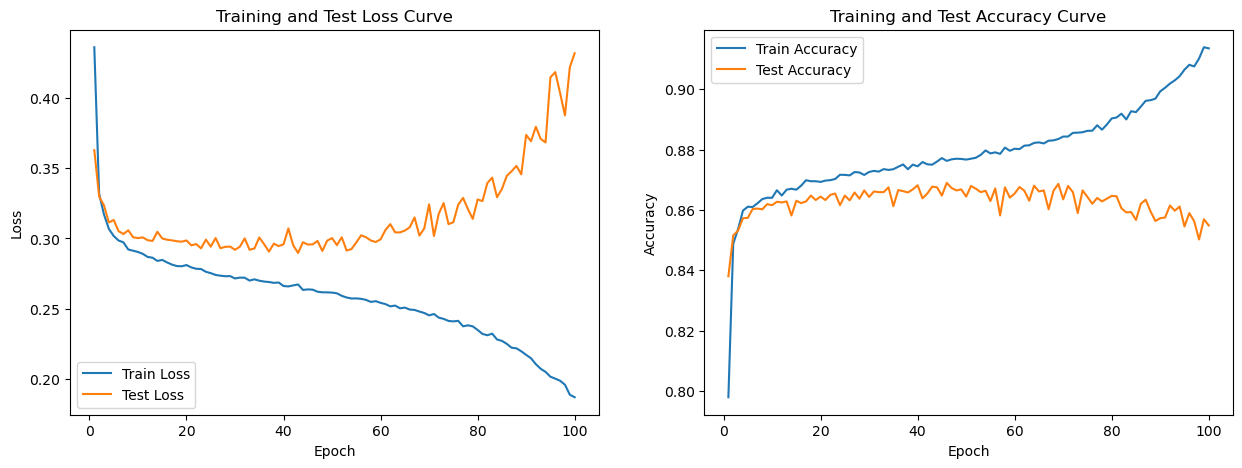

In [5]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                       embedding_dropout=0.1,
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                       cat_feat=cat_features,
                       embedding_scheme='rff_unique',
                       linear_on=True).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

# RFF to each feature - Linear*2

Epoch [ 1/100]       | Train: Loss 0.42930, Accuracy 0.80339                             | Test: Loss 0.34257, Accuracy 0.84475, F1 0.83419
Epoch [ 2/100]       | Train: Loss 0.33061, Accuracy 0.84700                             | Test: Loss 0.32267, Accuracy 0.85328, F1 0.84262
Epoch [ 3/100]       | Train: Loss 0.30773, Accuracy 0.85715                             | Test: Loss 0.32036, Accuracy 0.85282, F1 0.84033
Epoch [ 4/100]       | Train: Loss 0.30116, Accuracy 0.86022                             | Test: Loss 0.31294, Accuracy 0.85453, F1 0.84083
Epoch [ 5/100]       | Train: Loss 0.29968, Accuracy 0.86104                             | Test: Loss 0.30824, Accuracy 0.85874, F1 0.85437
Epoch [ 6/100]       | Train: Loss 0.29647, Accuracy 0.86177                             | Test: Loss 0.30627, Accuracy 0.86078, F1 0.85206
Epoch [ 7/100]       | Train: Loss 0.29262, Accuracy 0.86282                             | Test: Loss 0.30960, Accuracy 0.85453, F1 0.85525
Epoch [ 8/100]      

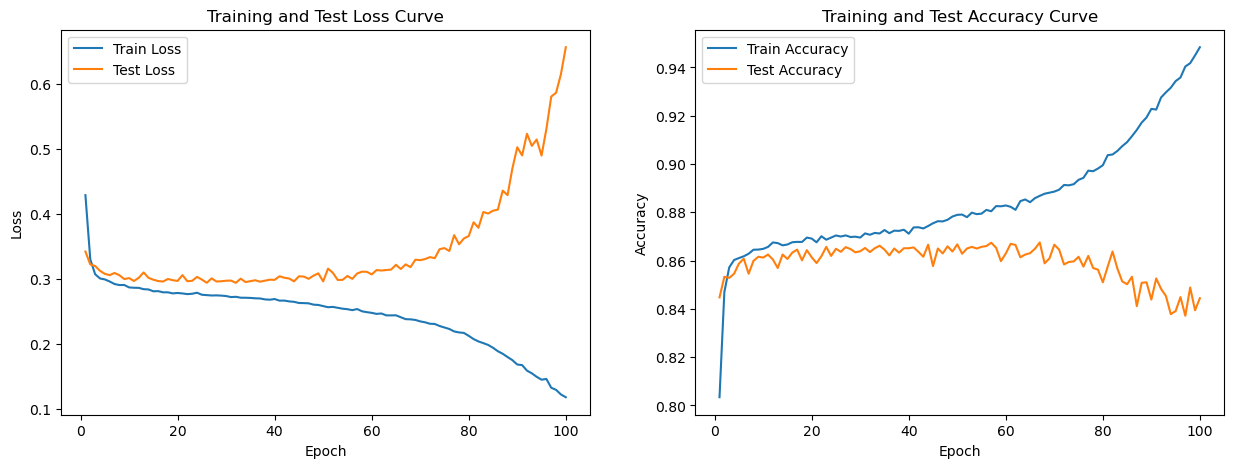

In [10]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                       embedding_dropout=0.1,
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                       cat_feat=cat_features,
                       embedding_scheme='rff_unique',
                       linear_on=True).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

# RFF - Linear * 2

Epoch [ 1/100]       | Train: Loss 0.44021, Accuracy 0.79482                             | Test: Loss 0.34696, Accuracy 0.84133, F1 0.83979
Epoch [ 2/100]       | Train: Loss 0.32200, Accuracy 0.85027                             | Test: Loss 0.32147, Accuracy 0.85168, F1 0.83935
Epoch [ 3/100]       | Train: Loss 0.30868, Accuracy 0.85639                             | Test: Loss 0.31987, Accuracy 0.85202, F1 0.83800
Epoch [ 4/100]       | Train: Loss 0.30211, Accuracy 0.85917                             | Test: Loss 0.31202, Accuracy 0.85794, F1 0.85710
Epoch [ 5/100]       | Train: Loss 0.29904, Accuracy 0.85943                             | Test: Loss 0.31315, Accuracy 0.86135, F1 0.85303
Epoch [ 6/100]       | Train: Loss 0.29602, Accuracy 0.86288                             | Test: Loss 0.30632, Accuracy 0.85976, F1 0.85056
Epoch [ 7/100]       | Train: Loss 0.29454, Accuracy 0.86297                             | Test: Loss 0.31119, Accuracy 0.85475, F1 0.84005
Epoch [ 8/100]      

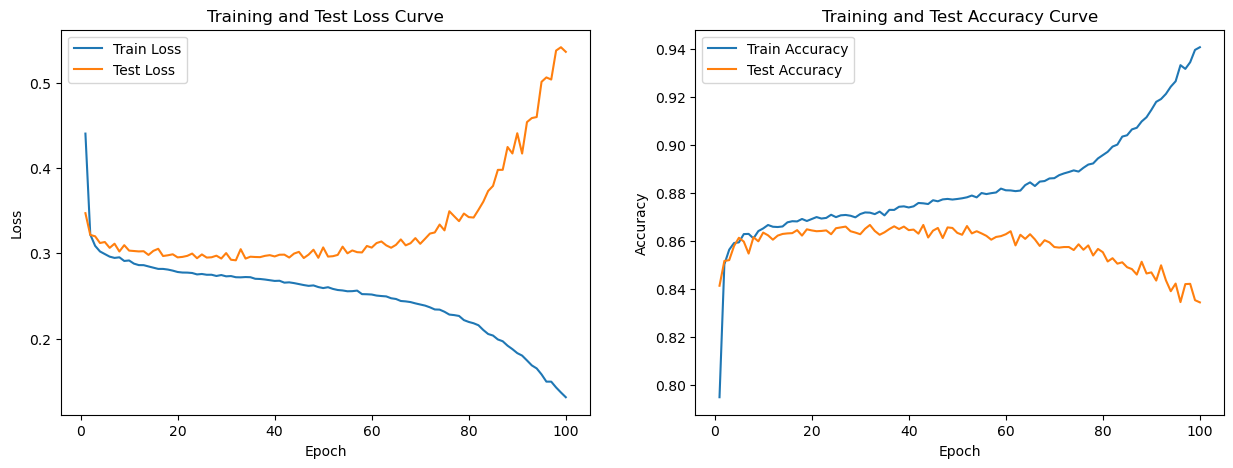

In [12]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                       embedding_dropout=0.1,
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                       cat_feat=cat_features,
                       embedding_scheme='rff',
                       linear_on=True).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")